In [45]:
"""
Here we are looking for a trading strategy using the AAII sentiment survey results. 

Data is from the AAII website. It is weekly data of the survey of its members. It asks its members how
they feel about the stock market. For each week they get a % bullish, % neutral, % bearish. 



"""
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd
import hvplot.pandas
from pathlib import Path
import alpaca_trade_api as tradeapi
import requests
import os 
from dotenv import load_dotenv
import plotly.express as px
import panel as pn
import hvplot
import hvplot.pandas

from backtesting import Backtest, Strategy
from backtesting.lib import crossover
from backtesting.test import SMA
from datetime import datetime, timedelta


pn.extension()

pd.set_option("display.max_rows", 2000)
pd.set_option("display.max_columns", 2000)
pd.set_option("display.width", 1000)

%matplotlib inline

In [46]:
#Read in AAII Sentiment data from csv

csvpath = Path(f"C:/Users/costa/Desktop/byte/rice/ru-hou-fin-pt-03-2020-u-c/Project_2_dream_team/sentiment.csv",
                  index_col="date", infer_datetime_format=True, parse_dates=True)
stock_data_df = pd.read_csv(csvpath)
stock_data_df['Date'] = pd.to_datetime(stock_data_df['Date'] )
stock_data_df.set_index('Date',inplace=True) 

#Change Monthly Close column to 'Close'
#stock_data_df.rename(columns={'SP500 Weekly Close': 'Close'},inplace=True)
#stock_data_df.drop(["Unnamed: 14"], axis=1, inplace=True)

stock_data_df.head(20)


,Bullish,Neutral,Bearish,Bull 8 wk mov avg,Bull 16 wk mov avg,Bear 8 wk mov avg,Bear 16 wk mov avg,Neutral 8 wk mov avg,Neutral 16 wk mov avg,Bull-Bear Spread,Close,Close in 4 wks,Close in 8 wks
Date,,,,,,,,,,,,,
NaT,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-06-26,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1987-07-17,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,314.59,333.99,321.98
1987-07-24,0.36,0.50,0.14,NaN,NaN,NaN,NaN,NaN,NaN,0.22,309.27,335.90,314.86
1987-07-31,0.26,0.48,0.26,NaN,NaN,NaN,NaN,NaN,NaN,0.00,318.66,323.04,320.16
1987-08-07,0.56,0.15,0.29,NaN,NaN,NaN,NaN,NaN,NaN,0.27,323.00,316.70,328.07
1987-08-14,0.45,0.35,0.20,NaN,NaN,NaN,NaN,NaN,NaN,0.25,333.99,321.98,311.07
1987-08-21,0.66,0.28,0.06,NaN,NaN,NaN,NaN,NaN,NaN,0.60,335.90,314.86,282.70
1987-08-28,0.52,0.18,0.30,NaN,NaN,NaN,NaN,NaN,NaN,0.22,323.04,320.16,248.22


In [47]:
#Clean data

#Sort earliest to latest.
stock_data_df.sort_index(inplace=True, ascending=True)

# Drop nulls
stock_data_df.dropna(inplace=True)

# drop duplicates
stock_data_df.drop_duplicates(inplace=True)

#count nulls 
stock_data_df.isnull().sum()

stock_data_df.head()


,Bullish,Neutral,Bearish,Bull 8 wk mov avg,Bull 16 wk mov avg,Bear 8 wk mov avg,Bear 16 wk mov avg,Neutral 8 wk mov avg,Neutral 16 wk mov avg,Bull-Bear Spread,Close,Close in 4 wks,Close in 8 wks
Date,,,,,,,,,,,,,
1987-11-06,0.47,0.31,0.22,0.46,0.29,0.26,0.25,0.28,0.29,0.25,250.41,223.92,247.08
1987-11-13,0.31,0.41,0.28,0.43,0.28,0.28,0.26,0.30,0.28,0.03,245.64,235.32,243.40
1987-11-20,0.39,0.42,0.19,0.41,0.28,0.26,0.25,0.33,0.28,0.20,242.00,249.16,252.05
1987-11-27,0.27,0.46,0.27,0.39,0.30,0.26,0.25,0.35,0.30,0.00,240.34,252.02,246.50
1987-12-04,0.25,0.33,0.42,0.36,0.30,0.29,0.27,0.35,0.30,-0.17,223.92,247.08,257.07


In [48]:
# To set up backtest using Bull/Bear spread 

#To set up the strategy select the columns we need, "Close", 'Bull-Bear Spread' and set to dataframe
signals_df = stock_data_df[['Bull-Bear Spread', 'Close']]

signals_df.head()


,Bull-Bear Spread,Close
Date,,
1987-11-06,0.25,250.41
1987-11-13,0.03,245.64
1987-11-20,0.20,242.00
1987-11-27,0.00,240.34
1987-12-04,-0.17,223.92


In [49]:
signals_df['Bull-Bear Spread'].describe()

count    1704.000000
mean        0.073680
std         0.176759
min        -0.540000
25%        -0.050000
50%         0.080000
75%         0.190000
max         0.630000
Name: Bull-Bear Spread, dtype: float64

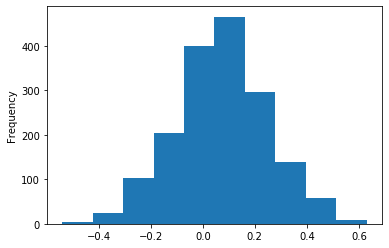

In [50]:
signals_df['Bull-Bear Spread'].plot.hist()

In [51]:
#Generate signals and put in dataframe

bull_bear_std = .176759
bull_bear_mean = .073680

# Set the short window and long windows
short_window = 1
long_window = 40  #This is equivalent to 10 months since this is weekly data.

#Set names of the windows
short_name = "SMA1"
long_name = "SMA40"

signals_df['SMA Signal']=0

# Generate the short and long moving averages 
signals_df[short_name] = signals_df["Close"].rolling(window=short_window).mean()
signals_df[long_name] = signals_df["Close"].rolling(window=long_window).mean()
# signals_df["Signal"] = 0.0

# Generate the trading signal 

#Sell when the bull bear spread is 2 std above the mean 

signals_df["Sell Signals"] = np.where(
     signals_df['Bull-Bear Spread'] > bull_bear_mean + 2*bull_bear_std, 1.0, 0.0
 )

#signals_df["Sell"] = signals_df["Sell Signals"].diff()

# Buy when the bull bear spread is 1.8 std below the mean (used 1.8 after some trial and error)

signals_df['Buy/Sell SMA'] = 0

signals_df["Buy Signals"] = np.where(
    signals_df['Bull-Bear Spread'] < bull_bear_mean - 1.8*bull_bear_std, 1.0, 0.0
)
#saved to csv and manually updated Buy/Sell SMA column


#signals_df.to_csv('sentiment_signals2.csv')
#signals_df["Buy"] = signals_df["Buy Signals"].diff()

# for index, row in signals_df.iterrows():

#     if row['Buy Signals'] == 1.0:
#         row['Buy/Sell SMA'] == 1.0
# #     elif row['Sell Signals'] == -1.0:
#         row['Buy/Sell SMA']= -1.0
    
      

# signals_df["SMA Signal"][short_window:] = np.where(
#     signals_df[short_name][short_window:] > signals_df[long_name][short_window:], -1.0, 0.0
# )

#signals_df["Buy/Sell SMA"] = signals_df["Sell Signals"]+ signals_df['Buy Signals']
signals_df["Signal"] = signals_df["Buy Signals"] - signals_df['Sell Signals']
    

#Calculate the points in time at which a position should be taken, 1 or -1


signals_df.head(10)


,Bull-Bear Spread,Close,SMA Signal,SMA1,SMA40,Sell Signals,Buy/Sell SMA,Buy Signals,Signal
Date,,,,,,,,,
1987-11-06,0.25,250.41,0,250.41,NaN,0.0,0,0.0,0.0
1987-11-13,0.03,245.64,0,245.64,NaN,0.0,0,0.0,0.0
1987-11-20,0.20,242.00,0,242.00,NaN,0.0,0,0.0,0.0
1987-11-27,0.00,240.34,0,240.34,NaN,0.0,0,0.0,0.0
1987-12-04,-0.17,223.92,0,223.92,NaN,0.0,0,0.0,0.0
1987-12-11,-0.09,235.32,0,235.32,NaN,0.0,0,0.0,0.0
1987-12-18,0.06,249.16,0,249.16,NaN,0.0,0,0.0,0.0
1987-12-24,0.08,252.02,0,252.02,NaN,0.0,0,0.0,0.0
1987-12-31,-0.01,247.08,0,247.08,NaN,0.0,0,0.0,0.0


In [60]:



def backtest(signals_df):
    backtest_df = signals_df[['Close', 'Buy Signals', 'Sell Signals', 'Signal']].copy()
    bt = backtest_df
    current_pos = 0
    cash = 100000
    bt['Current Position'] = current_pos
    bt['Current Cash'] = cash
    
    # add buy and hold column and variables
    buy_and_hold_cash = 100000
    buy_and_hold_shares = buy_and_hold_cash/bt['Close'].iloc[0] 
    bt["Buy&Hold Total"]= buy_and_hold_shares * bt['Close']
   
    for i, row in bt.iterrows():

        if bt.at[i, 'Signal'] == 1 and current_pos == 0:
            current_pos = cash/row["Close"]
            cash = 0
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash


        elif bt.at[i, 'Signal'] == 1 and current_pos != 0:
            current_pos = current_pos
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == -1 and current_pos != 0:   
            cash = cash + (bt.at[i, 'Close']* current_pos)
            current_pos = 0
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == -1 and current_pos == 0:
            current_pos = current_pos
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash

        elif bt.at[i, 'Signal'] == 0 and current_pos != 0:
            current_pos = current_pos
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash
        elif bt.at[i, 'Signal'] == 0 and current_pos == 0:
            current_pos = 0
            cash = cash
            bt.at[i, 'Current Position'] = current_pos
            bt.at[i, 'Current Cash'] = cash
            
    return backtest_df.round(2)


In [61]:
backtest(signals_df)

,Close,Buy Signals,Sell Signals,Signal,Current Position,Current Cash,Buy&Hold Total
Date,,,,,,,
1987-11-06,250.41,0.0,0.0,0.0,0,100000,100000.00
1987-11-13,245.64,0.0,0.0,0.0,0,100000,98095.12
1987-11-20,242.00,0.0,0.0,0.0,0,100000,96641.51
1987-11-27,240.34,0.0,0.0,0.0,0,100000,95978.60
1987-12-04,223.92,0.0,0.0,0.0,0,100000,89421.35
1987-12-11,235.32,0.0,0.0,0.0,0,100000,93973.88
1987-12-18,249.16,0.0,0.0,0.0,0,100000,99500.82
1987-12-24,252.02,0.0,0.0,0.0,0,100000,100642.95
1987-12-31,247.08,0.0,0.0,0.0,0,100000,98670.18


In [80]:
#Read in csv file
csvpath = Path(f"C:/Users/costa/Desktop/byte/rice/ru-hou-fin-pt-03-2020-u-c/Project_2_dream_team/sentiment_signals2.csv",
                  index_col="date", infer_datetime_format=True, parse_dates=True)
signals_df = pd.read_csv(csvpath)
#signals_df['Date'] = pd.to_datetime(signals_df['Date'] )

signals_df.set_index('Date',inplace=True)
signals_df.head(1000)

,Bull-Bear Spread,Close,SMA Signal,SMA1,SMA40,Sell Signals,Buy/Sell SMA,Buy Signals
Date,,,,,,,,
11/6/1987,0.25,250.41,0,250.41,NaN,0,0.0,0
11/13/1987,0.03,245.64,0,245.64,NaN,0,0.0,0
11/20/1987,0.20,242.00,0,242.00,NaN,0,0.0,0
11/27/1987,0.00,240.34,0,240.34,NaN,0,0.0,0
12/4/1987,-0.17,223.92,0,223.92,NaN,0,0.0,0
12/11/1987,-0.09,235.32,0,235.32,NaN,0,0.0,0
12/18/1987,0.06,249.16,0,249.16,NaN,0,0.0,0
12/24/1987,0.08,252.02,0,252.02,NaN,0,0.0,0
12/31/1987,-0.01,247.08,0,247.08,NaN,0,0.0,0


In [81]:
len(signals_df)

#signals_df['Close'].astype(float)
#signals_df.dtypes

1704

In [84]:
# Visualize exit position relative to close price
exit = signals_df[signals_df['Buy/Sell SMA'] == -1.0]['Close'].hvplot.scatter(
    color='red',
    marker='v',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize entry position relative to close price
entry = signals_df[signals_df['Buy/Sell SMA'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# # Visualize moving averages
moving_avgs = signals_df[['SMA1', 'SMA40']].hvplot(
     ylabel='Price in $',
     width=1000,
     height=400
)

# Overlay plots
entry_exit_plot = security_close * exit * moving_avgs * entry
entry_exit_plot.opts(xaxis=None)

#The sell signals (periods of 2 std of optimism) worked great at the 2000 peak but did not fire for the
#2007 peak. There were also many bad signals as the market rose in 2003.

:Overlay
   .Curve.I          :Curve   [Date]   (Close)
   .Scatter.Close.I  :Scatter   [Date]   (Close)
   .NdOverlay.I      :NdOverlay   [Variable]
      :Curve   [Date]   (value)
   .Scatter.Close.II :Scatter   [Date]   (Close)

In [85]:
#Now look at all buy signals

# Visualize entry position relative to close price
entry = signals_df[signals_df['Buy Signals'] == 1.0]['Close'].hvplot.scatter(
    color='green',
    marker='^',
    size=200,
    legend=False,
    ylabel='Price in $',
    width=1000,
    height=400
)

# Visualize close price for the investment
security_close = signals_df[['Close']].hvplot(
    line_color='lightgray',
    ylabel='Price in $',
    width=1000,
    height=400
)

# # Visualize moving averages
moving_avgs = signals_df[['SMA1', 'SMA40']].hvplot(
     ylabel='Price in $',
     width=1000,
     height=400
)

# Overlay plots
entry_exit_plot = security_close * entry * moving_avgs
entry_exit_plot.opts(xaxis=None)

#The periods of pessimism (2 sd, went to 1.8 sd to get more trades) does better at picking good points to buy although it has many false signals.
#If you throw out the cluster of bad signals in 2007 the rest of the signals are pretty good. 

#When used with the 10 month sma, a cluster of pessimism associated with a buy crossover of the smas (1 and 10 mo.) 
#helped pick good entry points in the 2000 and 2008 recessions. 

#In 2000, sell at top on sma sell signal, wait for cluster of pessimism and sma buy signal, then enter.
#In 2008, sell near top on sma sell signal, ignore clusters of pessimism until you get sma buy signal, then enter.
# So in 2020, we just had a cluster of pessimism followed by a sma buy signal so the market should continue up?


:Overlay
   .Curve.I       :Curve   [Date]   (Close)
   .Scatter.Close :Scatter   [Date]   (Close)
   .NdOverlay.I   :NdOverlay   [Variable]
      :Curve   [Date]   (value)

In [233]:
signals_df.head()


,Date,Bull-Bear Spread,Close,SMA Signal,SMA1,SMA40,Sell Signals,Buy Signals,Buy/Sell SMA,Shares,Portfolio Cash,Portfolio Total,Buy&Hold Total,Portfolio Daily Returns,Buy&Hold Daily Returns,Portfolio Cum Returns,Buy&Hold Cum Returns
18,1987-11-06,0.25,250.41,0.0,250.41,NaN,0.0,0.0,NaN,0.0,100000.0,100000.0,100000.0,NaN,NaN,NaN,NaN
19,1987-11-13,0.03,245.64,0.0,245.64,NaN,0.0,0.0,0.0,0.0,100000.0,100000.0,100000.0,0.0,0.0,0.0,0.0
20,1987-11-20,0.20,242.00,0.0,242.00,NaN,0.0,0.0,0.0,0.0,100000.0,100000.0,100000.0,0.0,0.0,0.0,0.0
21,1987-11-27,0.00,240.34,0.0,240.34,NaN,0.0,0.0,0.0,0.0,100000.0,100000.0,100000.0,0.0,0.0,0.0,0.0
22,1987-12-04,-0.17,223.92,0.0,223.92,NaN,0.0,0.0,0.0,0.0,100000.0,100000.0,100000.0,0.0,0.0,0.0,0.0


In [54]:

# Add share and cash columns

signals_df["Shares"] = float(0)
signals_df["Portfolio Cash"] = float(100000)

#Set up starting cash variable for sma strategy and buy and hold strategy

cash = 100000
buy_and_hold_cash = 100000


#Iterate through each row, use combinations of signal and buy/sell points to set shares and portfolio cash for each row.

for index, row in signals_df.iterrows():
    
    #If at a buy point, calculate the number of shares using total cash available and set the cash to zero
    
    if row['Buy/Sell SMA'] == 1.0:
       
        shares = cash/row['Close']
        row['Shares'] = shares
        row['Portfolio Cash']= 0 
       
    #If at sell point, calculate the cash generated from the sale (shares X closing price) and set the shares to zero, then
    #update the cash variable with the new cash balance'''
    
    elif row['Buy/Sell SMA'] == -1.0:
        row['Portfolio Cash']= shares*row['Close']
        cash = row['Portfolio Cash']
        row['Shares']= 0
        
    #If we are not at a buy or sell point, look to signal column, if the signal is buy, then set cash to zero and update shares.
    # If the signal is sell, update the cash column using cash variable
    else:
     
        row['Buy/Sell SMA'] == 0
        if row['SMA Signal']== 1:
            row['Portfolio Cash'] = 0
            row["Shares"]= shares
        elif row['SMA Signal'] == 0:
            row['Portfolio Cash'] = cash
        
# Add a Portfolio Total column
signals_df['Portfolio Total'] = signals_df['Portfolio Cash'] + (signals_df['Shares']*signals_df['Close'])

# Calculate how many shares a buy and hold investor could buy at the start of the comparison. Use end of long window as start. 
buy_and_hold_shares = buy_and_hold_cash/signals_df['Close'].iloc[long_window-1]

# Add a buy and hold total column for comparison, set the first 225 (long window) to 100000 so both portfolios are at 100000 at the
#end of the long window calculation
signals_df["Buy&Hold Total"]= buy_and_hold_shares * signals_df['Close']
signals_df["Buy&Hold Total"][0:long_window-1] = buy_and_hold_cash      
        
# Calculate the portfolio daily returns
signals_df['Portfolio Daily Returns'] = signals_df['Portfolio Total'].pct_change()  
signals_df['Buy&Hold Daily Returns']= signals_df['Buy&Hold Total'].pct_change()

# Calculate the cumulative returns
signals_df['Portfolio Cum Returns'] = (1 + signals_df['Portfolio Daily Returns']).cumprod() - 1
signals_df['Buy&Hold Cum Returns'] = (1 + signals_df['Buy&Hold Daily Returns']).cumprod() - 1

# Print the DataFrame
pd.set_option("display.max_rows", None, "display.max_columns", None)
signals_df.head(300)

,Date,Bull-Bear Spread,Close,SMA Signal,SMA1,SMA40,Sell Signals,Buy/Sell SMA,Buy Signals,Shares,Portfolio Cash,Portfolio Total,Buy&Hold Total,Portfolio Daily Returns,Buy&Hold Daily Returns,Portfolio Cum Returns,Buy&Hold Cum Returns
18,1987-11-06,0.25,250.41,0,250.41,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,NaN,NaN,NaN,NaN
19,1987-11-13,0.03,245.64,0,245.64,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
20,1987-11-20,0.20,242.00,0,242.00,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
21,1987-11-27,0.00,240.34,0,240.34,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
22,1987-12-04,-0.17,223.92,0,223.92,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
23,1987-12-11,-0.09,235.32,0,235.32,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
24,1987-12-18,0.06,249.16,0,249.16,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
25,1987-12-24,0.08,252.02,0,252.02,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
26,1987-12-31,-0.01,247.08,0,247.08,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000
27,1988-01-08,0.14,243.40,0,243.40,NaN,0.0,0,0.0,0.0,100000.0,100000.0,100000.000000,0.0,0.000000,0.0,0.000000


In [229]:
# Visualize exit position relative to total portfolio value
exit = signals_df[signals_df['Buy/Sell SMA'] == -1.0]['Portfolio Total'].hvplot.scatter(
    color='red',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize entry position relative to total portfolio value
entry = signals_df[signals_df['Buy/Sell SMA'] == 1.0]['Portfolio Total'].hvplot.scatter(
    color='green',
    legend=False,
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Visualize total portoflio value for the investment
total_portfolio_value = signals_df[['Portfolio Total']].hvplot(
    line_color='lightgray',
    ylabel='Total Portfolio Value',
    width=1000,
    height=400
)

# Overlay plots
portfolio_entry_exit_plot = total_portfolio_value * entry * exit
portfolio_entry_exit_plot.opts(xaxis=None)

:Overlay
   .Curve.I                    :Curve   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.I  :Scatter   [index]   (Portfolio Total)
   .Scatter.Portfolio_Total.II :Scatter   [index]   (Portfolio Total)

In [465]:
#Plot the SMA Strategy vs the Buy & Hold strategy

signals_df[["Buy&Hold Total", "Portfolio Total"]].hvplot()

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [466]:
#Prepare evaluation metrics dataframe

# Prepare DataFrame for metrics
metrics = [
    'Annual Return',
    'Cumulative Returns',
    'Annual Volatility',
    'Sharpe Ratio',
    'Sortino Ratio']

columns = ['Backtest', 'Buy&Hold']

# Initialize the DataFrame with index set to evaluation metrics and column as `Backtest` 
portfolio_evaluation_df = pd.DataFrame(index=metrics, columns=columns)
portfolio_evaluation_df

,Backtest,Buy&Hold
Annual Return,NaN,NaN
Cumulative Returns,NaN,NaN
Annual Volatility,NaN,NaN
Sharpe Ratio,NaN,NaN
Sortino Ratio,NaN,NaN


In [467]:
# Calculate cumulative return
portfolio_evaluation_df.loc['Cumulative Returns'][0] = signals_df['Portfolio Cum Returns'][-1]
portfolio_evaluation_df.loc['Cumulative Returns'][1] = signals_df['Buy&Hold Cum Returns'][-1]

portfolio_evaluation_df



,Backtest,Buy&Hold
Annual Return,NaN,NaN
Cumulative Returns,4.2322,2.46667
Annual Volatility,NaN,NaN
Sharpe Ratio,NaN,NaN
Sortino Ratio,NaN,NaN


In [468]:
# Calculate annualized return
portfolio_evaluation_df.loc['Annual Return'][0] = (signals_df['Portfolio Daily Returns'].mean() * 252)
portfolio_evaluation_df.loc['Annual Return'][1] = (signals_df['Buy&Hold Daily Returns'].mean() * 252)


portfolio_evaluation_df

,Backtest,Buy&Hold
Annual Return,0.0921462,0.0806558
Cumulative Returns,4.2322,2.46667
Annual Volatility,NaN,NaN
Sharpe Ratio,NaN,NaN
Sortino Ratio,NaN,NaN


In [469]:
# Calculate annual volatility
portfolio_evaluation_df.loc['Annual Volatility'][0] = (signals_df['Portfolio Daily Returns'].std() * np.sqrt(252))
portfolio_evaluation_df.loc['Annual Volatility'][1] = (signals_df['Buy&Hold Daily Returns'].std() * np.sqrt(252))
portfolio_evaluation_df

,Backtest,Buy&Hold
Annual Return,0.0921462,0.0806558
Cumulative Returns,4.2322,2.46667
Annual Volatility,0.135817,0.191703
Sharpe Ratio,NaN,NaN
Sortino Ratio,NaN,NaN


In [470]:
# Calculate Sharpe Ratio
portfolio_evaluation_df.loc['Sharpe Ratio'][0] = (
    signals_df['Portfolio Daily Returns'].mean() * 252) / (
    signals_df['Portfolio Daily Returns'].std() * np.sqrt(252)
)
portfolio_evaluation_df.loc['Sharpe Ratio'][1] = (
    signals_df['Buy&Hold Daily Returns'].mean() * 252) / (
    signals_df['Buy&Hold Daily Returns'].std() * np.sqrt(252)
)


portfolio_evaluation_df

,Backtest,Buy&Hold
Annual Return,0.0921462,0.0806558
Cumulative Returns,4.2322,2.46667
Annual Volatility,0.135817,0.191703
Sharpe Ratio,0.678457,0.420734
Sortino Ratio,NaN,NaN


In [471]:
# Calculate Downside Return
sortino_ratio_df = signals_df[['Portfolio Daily Returns']].copy()
sortino_ratio_df.loc[:,'Downside Returns'] = 0

target = 0
mask = sortino_ratio_df['Portfolio Daily Returns'] < target
sortino_ratio_df.loc[mask, 'Downside Returns'] = sortino_ratio_df['Portfolio Daily Returns']**2

sortino_ratio_df2 = signals_df[['Buy&Hold Daily Returns']].copy()
sortino_ratio_df2.loc[:,'Downside Returns1'] = 0

target = 0
mask = sortino_ratio_df2['Buy&Hold Daily Returns'] < target
sortino_ratio_df2.loc[mask, 'Downside Returns1'] = sortino_ratio_df2['Buy&Hold Daily Returns']**2


portfolio_evaluation_df

,Backtest,Buy&Hold
Annual Return,0.0921462,0.0806558
Cumulative Returns,4.2322,2.46667
Annual Volatility,0.135817,0.191703
Sharpe Ratio,0.678457,0.420734
Sortino Ratio,NaN,NaN


In [472]:
# Calculate Sortino Ratio
down_stdev = np.sqrt(sortino_ratio_df['Downside Returns'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df['Portfolio Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'][0] = sortino_ratio

down_stdev = np.sqrt(sortino_ratio_df2['Downside Returns1'].mean()) * np.sqrt(252)
expected_return = sortino_ratio_df2['Buy&Hold Daily Returns'].mean() * 252
sortino_ratio = expected_return/down_stdev

portfolio_evaluation_df.loc['Sortino Ratio'][1] = sortino_ratio





portfolio_evaluation_df

,Backtest,Buy&Hold
Annual Return,0.0921462,0.0806558
Cumulative Returns,4.2322,2.46667
Annual Volatility,0.135817,0.191703
Sharpe Ratio,0.678457,0.420734
Sortino Ratio,0.94619,0.591427


In [473]:
# Initialize trade evaluation DataFrame with columns
trade_evaluation_df = pd.DataFrame(
    columns=[
        'Stock', 
        'Entry Date', 
        'Exit Date', 
        'Shares', 
        'Entry Share Price', 
        'Exit Share Price', 
        'Entry Portfolio Holding', 
        'Exit Portfolio Holding', 
        'Profit/Loss']
)

trade_evaluation_df

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss


In [474]:
# Initialize iterative variables
entry_date = ''
exit_date = ''
entry_portfolio_holding = 0
exit_portfolio_holding = 0
share_size = 0
entry_share_price = 0
exit_share_price = 0

# Loop through signal DataFrame
# If `Entry/Exit` is 1, set entry trade metrics
# Else if `Entry/Exit` is -1, set exit trade metrics and calculate profit,
# Then append the record to the trade evaluation DataFrame
for index, row in signals_df.iterrows():
    if row['Buy/Sell'] == 1:
        entry_date = index
        entry_portfolio_holding = row['Shares']*row['Close']
        share_size = row['Shares']
        entry_share_price = row['Close']

    elif row['Buy/Sell'] == -1:
        exit_date = index
        exit_portfolio_holding = row['Portfolio Total']
        exit_share_price = row['Close']
        profit_loss = exit_portfolio_holding - entry_portfolio_holding
        trade_evaluation_df = trade_evaluation_df.append(
            {
                'Stock': 'SPY',
                'Entry Date': entry_date,
                'Exit Date': exit_date,
                'Shares': share_size,
                'Entry Share Price': entry_share_price,
                'Exit Share Price': exit_share_price,
                'Entry Portfolio Holding': entry_portfolio_holding,
                'Exit Portfolio Holding': exit_portfolio_holding,
                'Profit/Loss': profit_loss
            },
            ignore_index=True)

# Print the DataFrame
trade_evaluation_df
                

,Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss
0,SPY,2002-02-04,2002-03-04,1307.006732,76.5107,80.6182,100000.000000,105368.530153,5368.530153
1,SPY,2002-07-29,2002-08-23,1675.257925,62.8969,66.2810,105368.530153,111037.770496,5669.240342
2,SPY,2003-05-30,2003-06-26,1613.137961,68.8334,70.4010,111037.770496,113566.525563,2528.755067
3,SPY,2003-07-18,2004-11-26,1601.628693,70.9069,86.2802,113566.525563,138188.843947,24622.318384
4,SPY,2004-12-15,2004-12-17,1568.105695,88.1247,87.4889,138188.843947,137191.842346,-997.001601
5,SPY,2005-01-19,2008-03-06,1584.289226,86.5952,101.3263,137191.842346,160530.165357,23338.323011
6,SPY,2009-09-28,2010-11-19,1874.045384,85.6597,98.8290,160530.165357,185210.031229,24679.865872
7,SPY,2010-11-29,2011-02-09,1891.817121,97.9006,109.2424,185210.031229,206666.642651,21456.611422
8,SPY,2011-03-14,2011-11-25,1924.110969,107.4089,97.4773,206666.642651,187557.142152,-19109.500499
9,SPY,2012-04-23,2012-05-09,1619.073017,115.8423,114.9531,187557.142152,186117.462425,-1439.679727


In [475]:
#Create plots

price_df = signals_df[['Close', 'SMA215', 'SMA225']]
price_chart = price_df.hvplot.line()
price_chart.opts(xaxis=None)

:NdOverlay   [Variable]
   :Curve   [date]   (value)

In [476]:
portfolio_evaluation_df.reset_index(inplace=True)
portfolio_evaluation_table = portfolio_evaluation_df.hvplot.table()
portfolio_evaluation_table

:Table   [index,Backtest,Buy&Hold]

In [477]:
trade_evaluation_table = trade_evaluation_df.hvplot.table()
trade_evaluation_table

:Table   [Stock,Entry Date,Exit Date,Shares,Entry Share Price,Exit Share Price,Entry Portfolio Holding,Exit Portfolio Holding,Profit/Loss]

In [478]:
#Build dashboard with panel

# Create rows
price_chart_row = pn.Row(price_chart)
portfolio_evaluation_row = pn.Row(portfolio_evaluation_table)
trade_evaluation_row = pn.Row(trade_evaluation_table)

# Create columns
portfolio_column = pn.Column('# Portfolio Evaluation Metrics', price_chart_row, portfolio_evaluation_row)
trade_column = pn.Column('# Trade Evaluation Metrics', trade_evaluation_row)

# Create tabs
trading_dashboard = pn.Tabs(
    ("Portfolio Metrics", portfolio_column),
    ("Trade Metrics", trade_column)
)

In [449]:
trading_dashboard.servable()

Tabs
    [0] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(NdOverlay)
        [2] Row
            [0] HoloViews(Table)
    [1] Column
        [0] Markdown(str)
        [1] Row
            [0] HoloViews(Table)